#### Homework 3 
#### Eduardo Neville & Åke Janson 
#### Spring 2023

###### We import the packages to the jupyter notebook 

In [1]:
import numpy as np
from scipy.stats import norm 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
import pandas as pd

We then import the excel file and create a dataframe 

   NESN SW  ROG SW  NOVN SW  EURUSD  CHFUSD
0  21.3244   93.83    33.85  0.9517  0.6257
1  21.4767   93.97    35.05  0.9280  0.6129
2  20.3090   91.76    33.79  0.9495  0.6236
3  19.9987   91.19    32.32  0.9570  0.6258
4  20.3090   91.59    31.56  0.9467  0.6213


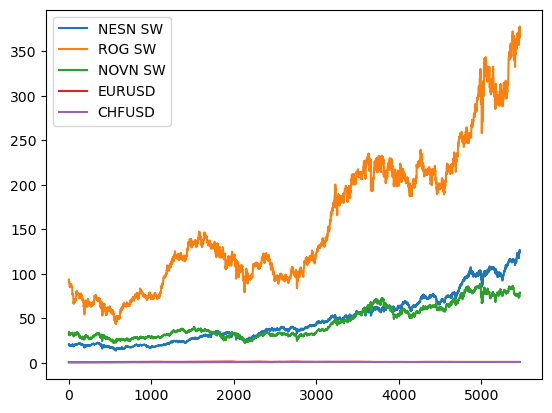

In [2]:
#read the excel file
data = pd.read_excel(r'data.xlsx') 
df = pd.DataFrame(data, columns = ['NESN SW', 'ROG SW', 'NOVN SW', 'EURUSD', 'CHFUSD'])
print(df.head())
# show the growth of the assets
plt.plot(df)
plt.legend(df.columns)

We then print the daily simple returns of each asset

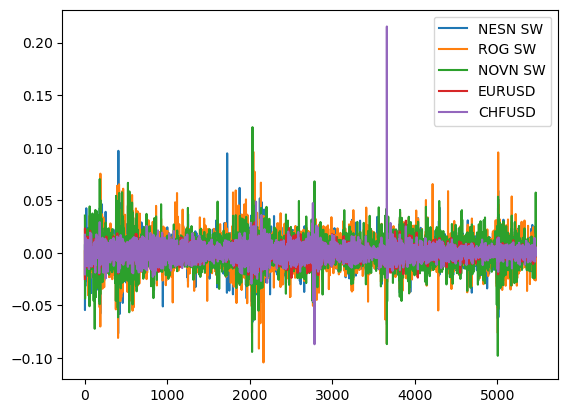

In [3]:
#calculate the daily simple returns
def percentage_change(df):
    returns = df.apply(lambda x: x.pct_change(1).dropna().reset_index(drop=True)) 
    return returns

#apply the function to the dataframe
plt.plot(percentage_change(df))
plt.legend(df.columns)
plt.show()

In [4]:
#calculate VaR and ES given the historical simulation method
def getVaR_ES(alpha, sorted_returns):
    index = int(np.ceil(alpha*(len(sorted_returns))))
    VaR = sorted_returns.apply(lambda x: -x[index])
    ES = sorted_returns.apply(lambda x: -x[:index].mean())
    return VaR, ES

In [5]:
#calculate returns, sort them, and calculate the VaR and ES (historical simulation method)
def var_esHist(alpha, df): 
    returns = percentage_change(df) 
    sorted_returns = returns.apply(lambda x: x.sort_values().reset_index(drop=True)) 
    return getVaR_ES(alpha, sorted_returns)

In [6]:
var_esHist(0.1,df), var_esHist(0.01,df), var_esHist(0.001,df)

((NESN SW    0.011707
  ROG SW     0.014220
  NOVN SW    0.013137
  EURUSD     0.006887
  CHFUSD     0.006993
  dtype: float64,
  NESN SW    0.020079
  ROG SW     0.024271
  NOVN SW    0.022133
  EURUSD     0.010519
  CHFUSD     0.011012
  dtype: float64),
 (NESN SW    0.031429
  ROG SW     0.037515
  NOVN SW    0.033238
  EURUSD     0.015343
  CHFUSD     0.015729
  dtype: float64,
  NESN SW    0.043163
  ROG SW     0.051699
  NOVN SW    0.047333
  EURUSD     0.018491
  CHFUSD     0.021021
  dtype: float64),
 (NESN SW    0.061237
  ROG SW     0.070041
  NOVN SW    0.061766
  EURUSD     0.021107
  CHFUSD     0.024128
  dtype: float64,
  NESN SW    0.066953
  ROG SW     0.085775
  NOVN SW    0.080138
  EURUSD     0.023852
  CHFUSD     0.040402
  dtype: float64))

In [7]:
#analytical computation of Value at Risk for a normally distributed random variable
def varNorm(mu, sigma, alpha):
    quantile = norm.ppf(alpha)
    return -mu - sigma*quantile

In [8]:
#analytical computation of Expected Shortfall for a normally distributed random variable
def esNorm(mu, sigma, alpha):
    quantile = norm.ppf(alpha)
    return -mu + sigma/alpha*norm.pdf(quantile)

# Monte Carlo Simulation

In [9]:
#Monte Carlo simulation method: Value at Risk for a normally distributed random variable
def varNormMC(mu, sigma, alpha, numSim):
    simulatedSample = np.random.normal(loc=mu, scale=sigma, size=numSim)
    return -np.quantile(simulatedSample, alpha)

In [10]:
#Monte Carlo simulation method: Expected Shortfall for a normally distributed random variable
def esNormMC(mu, sigma, alpha, numSim):
    simulatedSample = np.random.normal(loc=mu, scale=sigma, size=numSim)
    sortedSample = np.sort(simulatedSample)
    index = int(np.ceil(numSim*alpha))
    return -np.average(sortedSample[0:index])

In [11]:
mu, sigma, alpha = 0.04, 0.15, 0.01
varNorm(mu, sigma, alpha), esNorm(mu, sigma, alpha)

(0.3089521811061261, 0.35978213305187123)

In [12]:
numSim = 1000
varNormMC(mu, sigma, alpha, numSim), esNormMC(mu, sigma, alpha, numSim)

(0.2814775365540808, 0.35951929657161913)

In [13]:
#bootstrapped distribution of MC computed Value at Risk and Expected Shortfall for a Gaussian random variable
def bootstrapNormVaRES(mu, sigma, alpha, numSim, numBootstraps, numBins):
    varDistribution = np.empty(numBootstraps)
    esDistribution = np.empty(numBootstraps)
    for i in range(numBootstraps):
        varDistribution[i] = varNormMC(mu, sigma, alpha, numSim)
        esDistribution[i] = esNormMC(mu, sigma, alpha, numSim)
    plt.hist(varDistribution, numBins)
    plt.legend(['VaR'])
    plt.title("Value at Risk distribution with alpha {} and {} simulations".format(alpha, numSim))
    plt.show()
    plt.hist(esDistribution, numBins)
    plt.legend(['ES'])
    plt.title("Expected Shortfall distribution with alpha {} and {} simulations".format(alpha, numSim))
    plt.show()

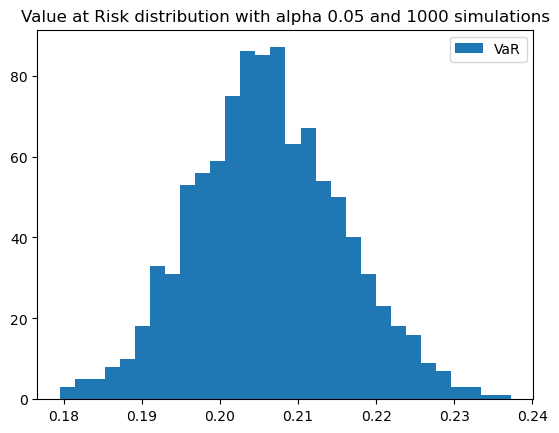

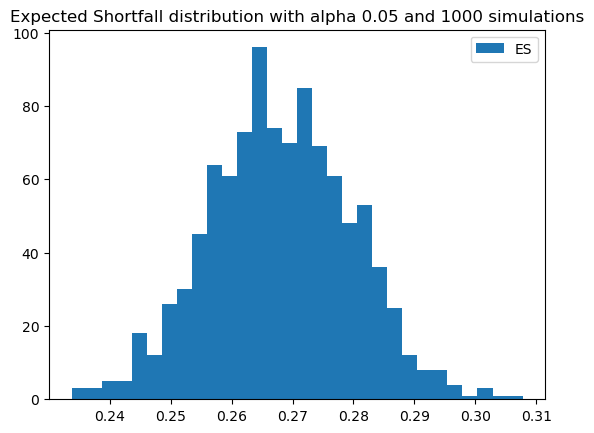

In [14]:
numSim = 100
numBootstraps = 1000
numBins = 30
alpha = 0.05
#bootstrapNormVaRES(mu, sigma, alpha, numSim, numBootstraps, numBins)
numSim = 1000
bootstrapNormVaRES(mu, sigma, alpha, numSim, numBootstraps, numBins)

In [15]:
#calculate returns, fit a univariate normal distribution, and calculate VaR and ES given the variance-covariance method under Gaussianity
def var_esVarCovNorm(alpha, df): 
    returns = percentage_change(df) 
    moments = returns.apply(lambda x: norm.fit(x)) 
    return moments.apply(lambda x: varNorm(x[0], x[1], alpha)), moments.apply(lambda x: esNorm(x[0], x[1], alpha)) 
def var_esVarCovNorm_withstd(alpha, df): 
    returns = percentage_change(df) 
    moments = returns.apply(lambda x: norm.fit(x)) 
    
    var_values = moments.apply(lambda x: varNorm(x[0], x[1], alpha))
    es_values = moments.apply(lambda x: esNorm(x[0], x[1], alpha))
    std_values = moments.apply(lambda x: x[1])  
    
    result_df = pd.concat([var_values, es_values, std_values], axis=1)
    result_df.columns = ['VaR', 'ES', 'std']  
    
    return result_df

In [16]:
var_esVarCovNorm_withstd(0.05, df), var_esVarCovNorm_withstd(0.01, df)#, var_esVarCovNorm_withstd(0.001, df) 


(              VaR        ES       std
 NESN SW  0.018258  0.022995  0.011337
 ROG SW   0.022191  0.027917  0.013703
 NOVN SW  0.020417  0.025664  0.012555
 EURUSD   0.009536  0.011970  0.005827
 CHFUSD   0.011267  0.014161  0.006926,
               VaR        ES       std
 NESN SW  0.025984  0.029826  0.011337
 ROG SW   0.031529  0.036173  0.013703
 NOVN SW  0.028974  0.033228  0.012555
 EURUSD   0.013507  0.015481  0.005827
 CHFUSD   0.015987  0.018334  0.006926)

In [18]:
#difference between the historical simulation and the variance-covariance (Gaussian-based) estimation
print(var_esHist(0.1,df)[0]-var_esVarCovNorm(0.1, df)[0])
print(var_esHist(0.1,df)[1]-var_esVarCovNorm(0.1, df)[1])
print(var_esHist(0.01,df)[0]-var_esVarCovNorm(0.01, df)[0]) 
print(var_esHist(0.01,df)[1]-var_esVarCovNorm(0.01, df)[1])
print(var_esHist(0.001,df)[0]-var_esVarCovNorm(0.001, df)[0])
print(var_esHist(0.001,df)[1]-var_esVarCovNorm(0.001, df)[1])

KeyError: 0